In [1]:
using Turing 
using Distributions
using Random
using Statistics

using CSVFiles
using DataFrames

using Plots
using CairoMakie
CairoMakie.activate!()

### section 5-1
#### multiple regression

In [ ]:
df = DataFrame(load(File(format"CSV", "data-attendance-1.txt")))

# A: アルバイトが好き => 1, 嫌い => 0
# Score: 学問への興味: 0 ~ 200
# Y: 出席率

Row,A,Score,Y
,Int64,Int64,Float64
1,0,69,0.286
2,1,145,0.196
3,0,125,0.261
4,1,86,0.109
5,1,158,0.23
6,0,133,0.35
7,0,111,0.33
8,1,147,0.194
9,0,146,0.413


In [ ]:
# scatter plot matrix
function scatter_matrix(df, cols)
    N_col = length(cols)
    labels = string.(cols)
    
    fig = Figure(size=(1500, 1500))
    ax_matrix = [Axis(fig[i, j], xlabel = labels[j], xlabelsize = 30, ylabel = labels[i], ylabelsize = 30) for i = 1 : N_col, j = 1 : N_col]
    for i = 1 : N_col, j = 1 : N_col
        if i != N_col
            hidexdecorations!(ax_matrix[i, j], grid=false)
        end
        if j != 1
            hideydecorations!(ax_matrix[i, j], grid=false)
        end
    end

    # diagonal plot
    for (i, col) ∈ enumerate(cols)
        if i == 1
            hist!(ax_matrix[i, i], df[df.A .== 0, col], color = (:orange, 0.5), strokewidth = 1, strokecolor = :black)
            hist!(ax_matrix[i, i], df[df.A .== 1, col], color = (:green, 0.5), strokewidth = 1, strokecolor = :black)
        else 
            Makie.density!(ax_matrix[i, i], df[!, col], color = (:gray50, 0.9))
            hist!(ax_matrix[i, i], df[!, col], color = (:blue, 0.5), strokewidth = 1, strokecolor = :black, normalization = :pdf)
        end
    end

    # upper diagonal plot 
    for i = 1 : N_col - 1
        for j = i+1 : N_col
            _correlation_plot!(ax_matrix[i, j], df[!, cols[i]], df[!, cols[j]])
        end
    end

    # lower diagonal plot 
    colors = [(:orange, 0.7), (:green, 0.7)]
    markers = [:circle, :utriangle]
    Random.seed!(1234)
    random_offsets = 0.3 .* (rand(Float64, nrow(df)) .- 0.5) 
    for j = 1 : N_col - 1
        for i = j+1 : N_col
            if j == 1 
                Makie.boxplot!(ax_matrix[i, j], df[!, :A], df[!, cols[i]], color = :white, strokewidth = 1, strokecolor = :black)
                Makie.scatter!(ax_matrix[i, j], df[!, :A] + random_offsets, df[!, cols[i]], color = colors[df.A .+ 1], markersize = 20, marker = markers[df.A .+ 1])
            else
                Makie.scatter!(ax_matrix[i, j], df[df.A .== 0, cols[j]], df[df.A .== 0, cols[i]], markersize = 20, marker = :circle, color = (:orange, 0.7))
                Makie.scatter!(ax_matrix[i, j], df[df.A .== 1, cols[j]], df[df.A .== 1, cols[i]], markersize = 20, marker = :utriangle, color = (:green, 0.7))
            end
        end
    end

    display(fig)
end

function _correlation_plot!(axis, data1, data2)
    pearson_cor = cor(data1, data2)

    color_scale = min(0.01 + abs(pearson_cor), 0.8)
    θ = sign(pearson_cor) * (π / 4.0)
    ellipse_scale = 1.0 - abs(pearson_cor) * 0.5
    ellipse_polygon = Point2f.(zip(_ellipse_points(0, 0, ellipse_scale, 1.0 / ellipse_scale, θ)...))

    hidedecorations!(axis)
    hidespines!(axis)
    plot = poly!(axis, ellipse_polygon, color = color_scale, colormap = :blues, colorrange = (0, 1.0))
    text!(axis, 0, 0, text = "$(round(pearson_cor, digits=2))", align = (:center, :center), fontsize = 50)
end

function _ellipse_points(center_x, center_y, radius_x, radius_y, θ; points=100)
	t = range(0, 2*pi, length=points)
	ellipse_x_r = radius_x .* cos.(t)
	ellipse_y_r = radius_y .* sin.(t)
	R = [cos(θ) -sin(θ); sin(θ) cos(θ)]
	r_ellipse = [ellipse_x_r ellipse_y_r] * R
	x = center_x .+ r_ellipse[:, 1]
	y = center_y .+ r_ellipse[:, 2]
	return (x, y)
end

_ellipse_points (generic function with 1 method)

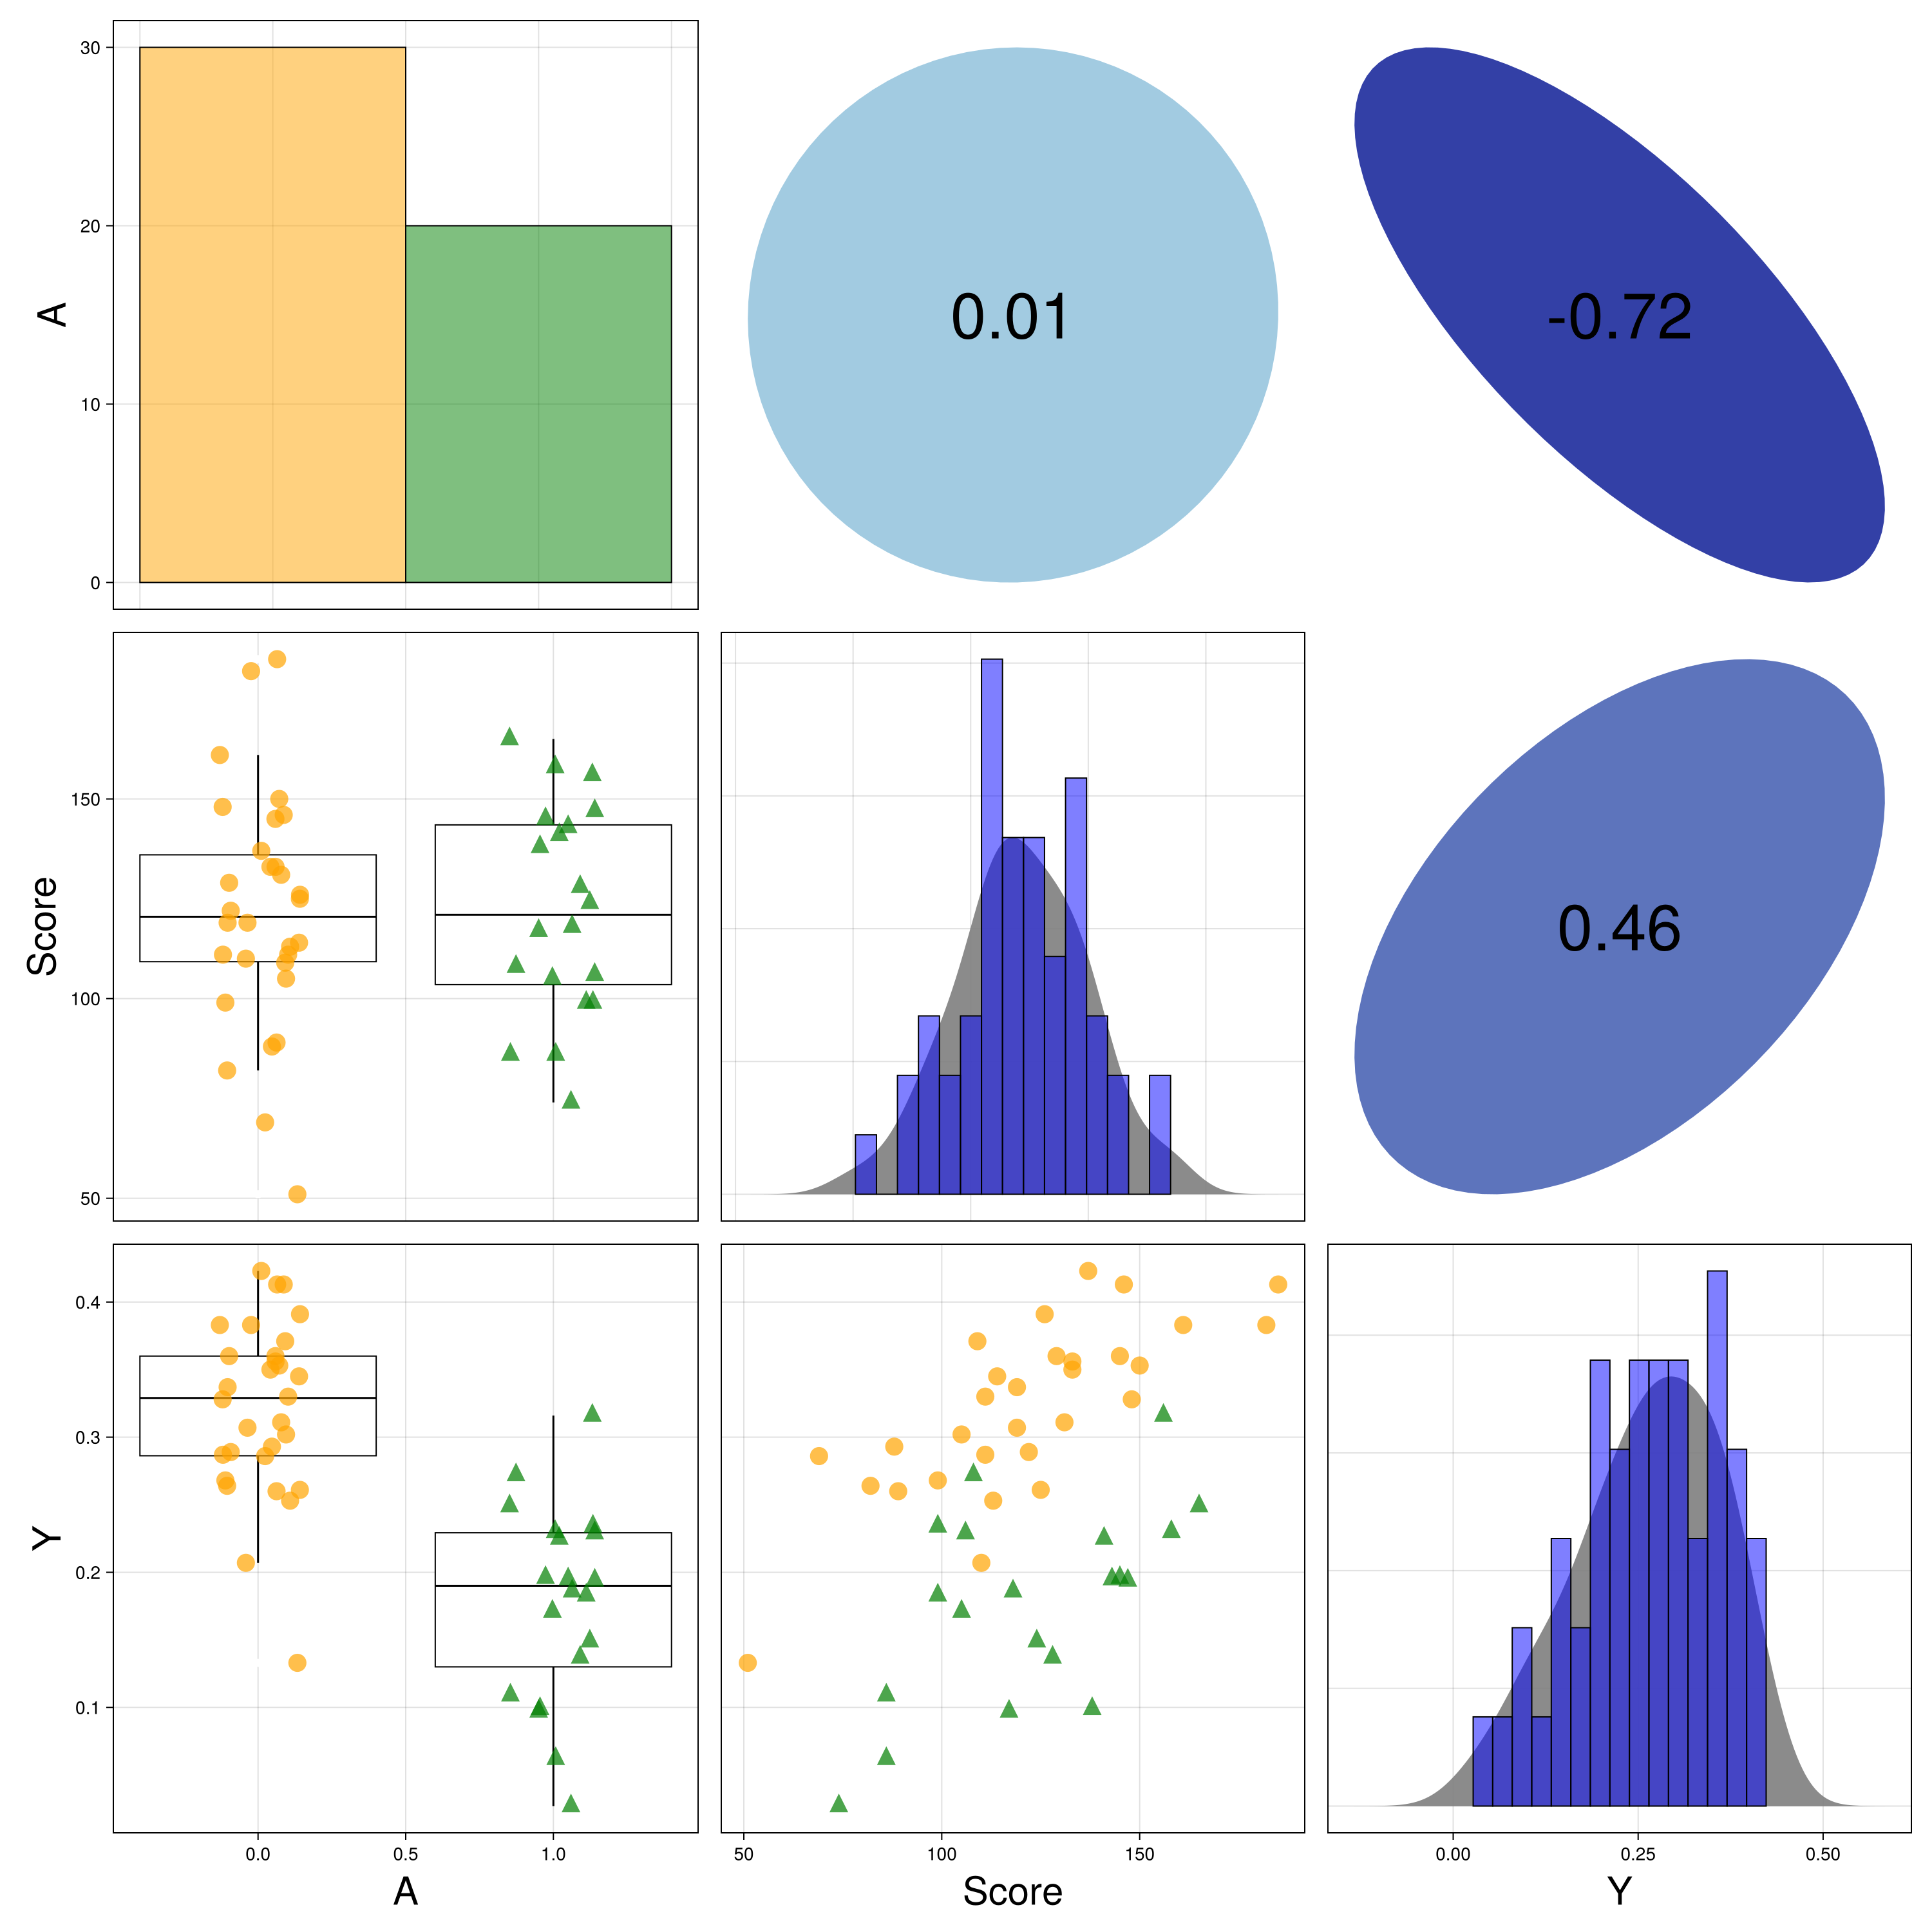

CairoMakie.Screen{IMAGE}


In [4]:
scatter_matrix(df, [:A, :Score, :Y])

In [5]:
# 仮説：YはAとScoreによって（線形に）説明できる
@model function multi_linear(A, Score, Y)
    # scale constant
    score_scale = 200

    # prior distribution
    b_0 ~ Normal(0, 100)
    b_A ~ Normal(0, 100)
    b_score ~ Normal(0, 100)
    σ² ~ truncated(Normal(0, 100), lower=0)

    # model
    for i = 1 : length(A)
        Y[i] ~ b_0 + b_A * A[i] + b_score * Score[i] / score_scale + Normal(0, σ²)
    end
end

multi_linear (generic function with 2 methods)

In [6]:
A = df[!, :A]
Score = df[!, :Score]
Y = df[!, :Y]
chain = sample(multi_linear(A, Score, Y), NUTS(), 1000)

┌ Info: Found initial step size
└   ϵ = 0.003125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (1000×18×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 12.27 seconds
Compute duration  = 12.27 seconds
parameters        = b_0, b_A, b_score, σ²
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

         b_0    0.1207    0.0346    0.0018   379.4432   412.2011    1.0087     ⋯
         b_A   -0.1432    0.0140    0.0005   655.9275   585.6935    1.0010     ⋯
     b_score    0.3292    0.0548    0.0029   356.3123   447.1658    1.0049     ⋯
          σ²    0.0518    0.0055    0.0002   675.0072   442.7807    1.0085     ⋯
                          

In [7]:
df2 = DataFrame(chain)

Row,iteration,chain,b_0,b_A,b_score,σ²,n_steps,is_accept,acceptance_rate,log_density,hamiltonian_energy,hamiltonian_energy_error,max_hamiltonian_energy_error,tree_depth,numerical_error,step_size,nom_step_size,lp,logprior,loglikelihood
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,501,1,0.129101,-0.148028,0.321173,0.0556934,15.0,1.0,0.993217,54.8656,-54.1118,-0.0293012,-0.0689665,4.0,0.0,0.195232,0.195232,57.7535,-21.4033,79.1568
2,502,1,0.131699,-0.135928,0.305235,0.0649579,15.0,1.0,0.724135,52.3502,-51.1452,0.136166,1.33306,3.0,0.0,0.195232,0.195232,55.0843,-21.4033,76.4876
3,503,1,0.0749011,-0.128063,0.392944,0.0415957,15.0,1.0,0.991893,51.7952,-49.5702,-0.033257,0.0347898,4.0,0.0,0.195232,0.195232,54.975,-21.4033,76.3783
4,504,1,0.149449,-0.16444,0.296059,0.0477372,15.0,1.0,0.775453,54.2257,-47.9849,0.0789957,0.659042,4.0,0.0,0.195232,0.195232,57.2678,-21.4033,78.6711
5,505,1,0.149366,-0.162777,0.309228,0.0472725,7.0,1.0,0.782082,53.5907,-53.2669,0.427335,0.468038,3.0,0.0,0.195232,0.195232,56.6426,-21.4033,78.0459
6,506,1,0.0919477,-0.126376,0.39088,0.0531607,15.0,1.0,0.518743,51.741,-49.825,1.05711,1.67674,4.0,0.0,0.195232,0.195232,54.6755,-21.4033,76.0788
7,507,1,0.0975412,-0.122249,0.397045,0.054034,7.0,1.0,0.49229,47.2632,-45.409,1.72405,2.1768,2.0,0.0,0.195232,0.195232,50.1813,-21.4033,71.5846
8,508,1,0.104315,-0.127268,0.332745,0.0457701,31.0,1.0,0.935785,53.8041,-48.6642,-3.80954,-3.80954,4.0,0.0,0.195232,0.195232,56.8882,-21.4033,78.2915
9,509,1,0.135264,-0.142281,0.294622,0.0509633,15.0,1.0,0.989143,55.031,-52.0518,-0.124595,-0.359215,4.0,0.0,0.195232,0.195232,58.0076,-21.4033,79.4109


In [ ]:
score_pred = collect(1 : 200)
μ_0 = chain[:b_0] .+ chain[:b_A] .* 0 .+ chain[:b_score] * score_pred' / 200 
μ_1 = chain[:b_0] .+ chain[:b_A] .* 1 .+ chain[:b_score] * score_pred' / 200
mean_μ_0 = vec(mean(μ_0, dims=1)')
mean_μ_1 = vec(mean(μ_1, dims=1)')
Y_pred_0 = rand.(Normal.(μ_0, chain[:σ²]))
Y_pred_1 = rand.(Normal.(μ_1, chain[:σ²]))

# 80% 信頼区間
# A = 0
lower_conf_0 = [quantile(μ_0[:, i], 0.10) for i = 1 : length(score_pred)]
upper_conf_0 = [quantile(μ_0[:, i], 0.90) for i = 1 : length(score_pred)]
# A = 1
lower_conf_1 = [quantile(μ_1[:, i], 0.10) for i = 1 : length(score_pred)]
upper_conf_1 = [quantile(μ_1[:, i], 0.90) for i = 1 : length(score_pred)]

# 80% 予測区間
# A = 0
lower_pred_0 = [quantile(Y_pred_0[:, i], 0.10) for i = 1 : length(score_pred)]
upper_pred_0 = [quantile(Y_pred_0[:, i], 0.90) for i = 1 : length(score_pred)]
# A = 1
lower_pred_1 = [quantile(Y_pred_1[:, i], 0.10) for i = 1 : length(score_pred)]
upper_pred_1 = [quantile(Y_pred_1[:, i], 0.90) for i = 1 : length(score_pred)]

lower_errors_0 = mean_μ_0 .- lower_pred_0
upper_errors_0 = upper_pred_0 .- mean_μ_0
lower_errors_1 = mean_μ_1 .- lower_pred_1
upper_errors_1 = upper_pred_1 .- mean_μ_1


200-element Vector{Float64}:
 0.07959674093081823
 0.07619245460027407
 0.08034374033654652
 0.07855469325669195
 0.07428341610303028
 0.07785089033185787
 0.08524750077978552
 0.07702601538114943
 0.07700525459118741
 0.07688060878579533
 0.07968924643306492
 0.07398574840130438
 0.08173664639821449
 ⋮
 0.0650056773635565
 0.07425058119165157
 0.0704596459367921
 0.0712317957714807
 0.07507580518840767
 0.07261035803393046
 0.07540687137494428
 0.06947993517312145
 0.06812779433624061
 0.07315157379475135
 0.07360901088264449
 0.0731391471772655

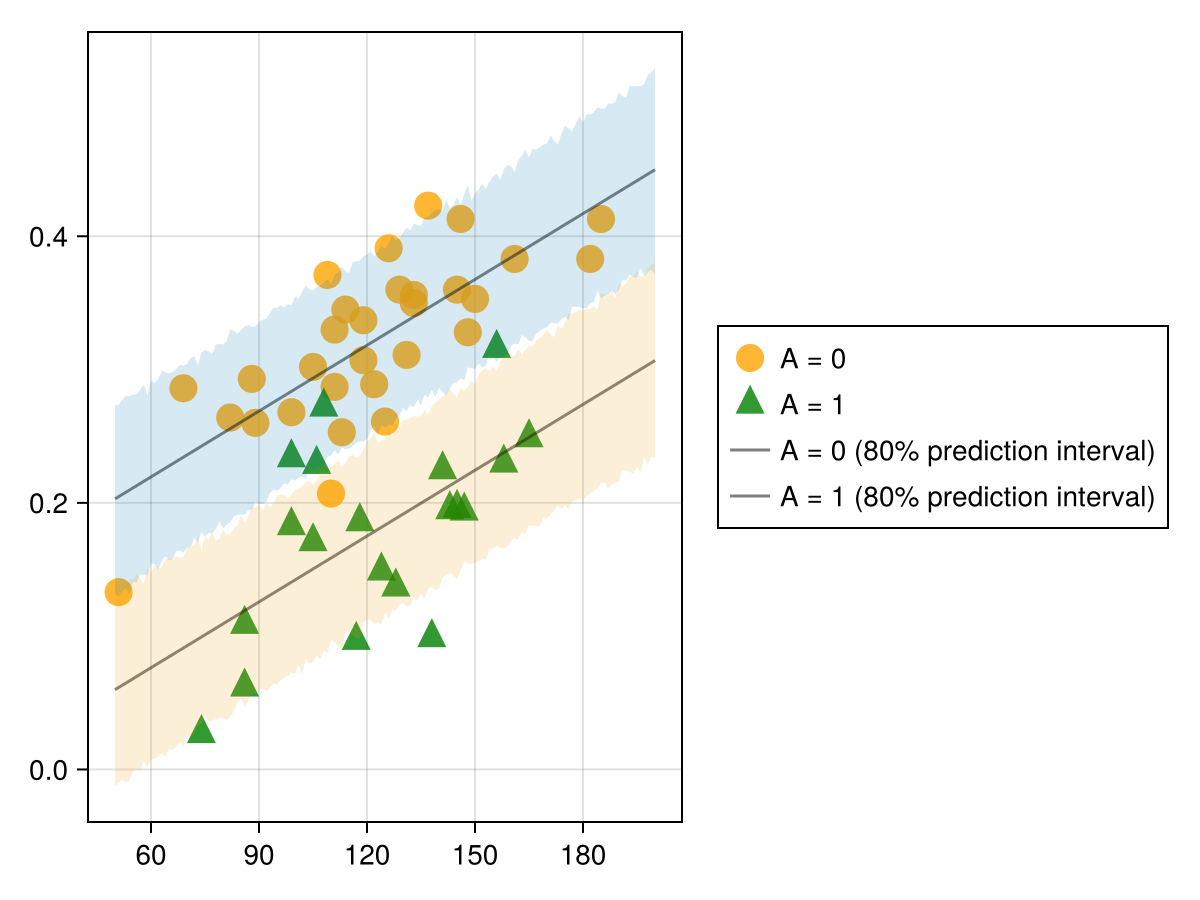

CairoMakie.Screen{IMAGE}


In [16]:
# 80% prediction interval
fig = Figure()
ax = Axis(fig[1, 1])

sca1 = Makie.scatter!(ax, df[df.A .== 0, :Score], df[df.A .== 0, :Y], markersize = 20, marker = :circle, color = (:orange, 0.8))
sca2 = Makie.scatter!(ax, df[df.A .== 1, :Score], df[df.A .== 1, :Y], markersize = 20, marker = :utriangle, color = (:green, 0.8))
lin1 = Makie.lines!(ax, 50:200, mean_μ_0[50:200], color = (:black, 0.5))
lin2 = Makie.lines!(ax, 50:200, mean_μ_1[50:200], color = (:black, 0.5))
Makie.band!(ax, 50:200, lower_pred_0[50:200], upper_pred_0[50:200], alpha=0.2)
Makie.band!(ax, 50:200, lower_pred_1[50:200], upper_pred_1[50:200], alpha=0.2)

Legend(fig[1, 2], [sca1, sca2, lin1, lin2], ["A = 0", "A = 1", "A = 0 (80% prediction interval)", "A = 1 (80% prediction interval)"])

display(fig)

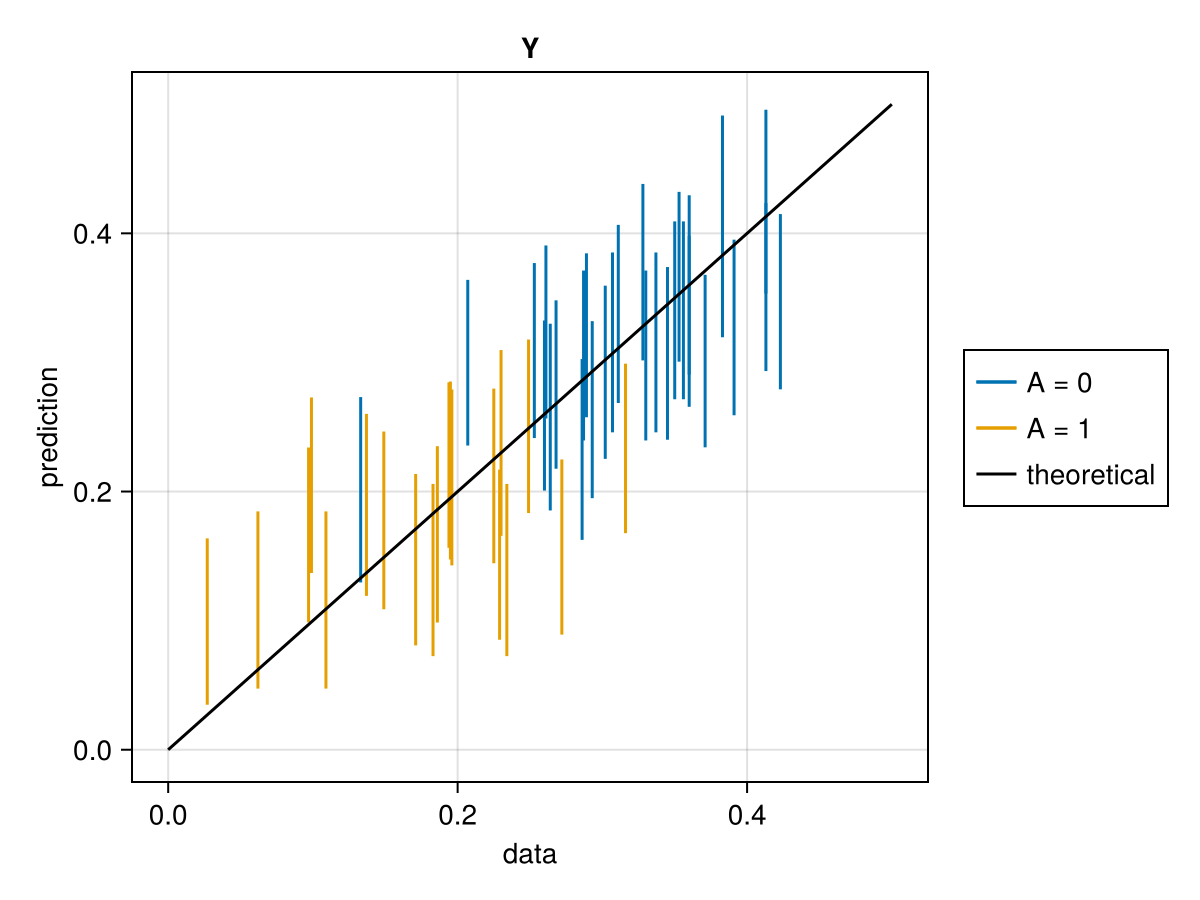

CairoMakie.Screen{IMAGE}


In [31]:
# 実測値・予測値 plot 
fig = Figure()
ax = Axis(fig[1, 1], title="Y", xlabel="data", ylabel="prediction")

err1 = Makie.errorbars!(ax, df[df.A .== 0, :Y], mean_μ_0[df[df.A .== 0, :Score]], lower_errors_0[df[df.A .== 0, :Score]], upper_errors_0[df[df.A .== 0, :Score]])
err2 = Makie.errorbars!(ax, df[df.A .== 1, :Y], mean_μ_1[df[df.A .== 1, :Score]], lower_errors_1[df[df.A .== 1, :Score]], upper_errors_1[df[df.A .== 1, :Score]])
lin = Makie.lines!(ax, 0:0.1:0.5, x -> x, color=:black)

Legend(fig[1, 2], [err1, err2, lin], ["A = 0", "A = 1", "theoretical"])

display(fig)

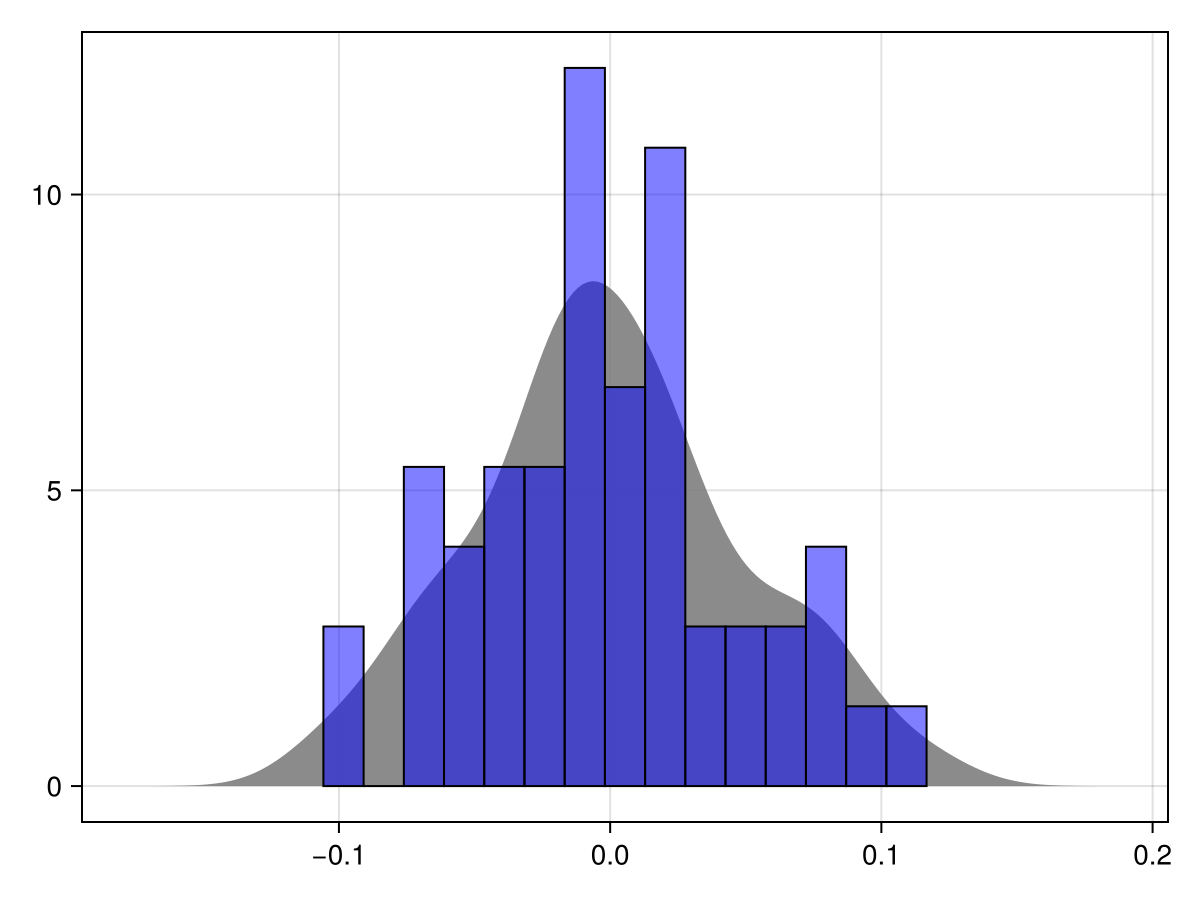

CairoMakie.Screen{IMAGE}


In [44]:
# 誤差解析
ϵ_0 = df[df.A .== 0, :Y] .- mean_μ_0[df[df.A .== 0, :Score]] 
ϵ_1 = df[df.A .== 1, :Y] .- mean_μ_1[df[df.A .== 1, :Score]]
ϵ = vcat(ϵ_0, ϵ_1)

gaussian(x, σ²) = 1.0 / sqrt(2.0 * π * σ²) * exp(- x^2 / (2.0 * σ²)) 

fig = Figure()
ax = Axis(fig[1, 1])

Makie.density!(ax, ϵ, color = (:gray50, 0.9))
hist!(ax, ϵ, color = (:blue, 0.5), strokewidth = 1, strokecolor = :black, normalization = :pdf)

display(fig)

In [49]:
# samples' scatter matrix
function scatter_matrix2(df, cols)
    N_col = length(cols)
    labels = string.(cols)
    
    fig = Figure(size=(1500, 1500))
    ax_matrix = [Axis(fig[i, j], xlabel = labels[j], xlabelsize = 30, ylabel = labels[i], ylabelsize = 30) for i = 1 : N_col, j = 1 : N_col]
    for i = 1 : N_col, j = 1 : N_col
        if i != N_col
            hidexdecorations!(ax_matrix[i, j], grid=false)
        end
        if j != 1
            hideydecorations!(ax_matrix[i, j], grid=false)
        end
    end

    # diagonal plot
    for (i, col) ∈ enumerate(cols)    
        Makie.density!(ax_matrix[i, i], df[!, col], color = (:gray50, 0.9))
        hist!(ax_matrix[i, i], df[!, col], color = (:blue, 0.5), strokewidth = 1, strokecolor = :black, normalization = :pdf)
    end

    # upper diagonal plot 
    for i = 1 : N_col - 1
        for j = i+1 : N_col
            _correlation_plot!(ax_matrix[i, j], df[!, cols[i]], df[!, cols[j]])
        end
    end

    # lower diagonal plot  
    for j = 1 : N_col - 1
        for i = j+1 : N_col
            Makie.scatter!(ax_matrix[i, j], df[!, cols[j]], df[!, cols[i]])
        end
    end

    display(fig)
end

function _correlation_plot!(axis, data1, data2)
    pearson_cor = cor(data1, data2)

    color_scale = 0.01 + abs(pearson_cor) * 0.6
    θ = sign(pearson_cor) * (π / 4.0)
    ellipse_scale = 1.0 - abs(pearson_cor) * 0.5
    ellipse_polygon = Point2f.(zip(_ellipse_points(0, 0, ellipse_scale, 1.0 / ellipse_scale, θ)...))

    hidedecorations!(axis)
    hidespines!(axis)
    plot = poly!(axis, ellipse_polygon, color = color_scale, colormap = :blues, colorrange = (0, 1.0))
    text!(axis, 0, 0, text = "$(round(pearson_cor, digits=2))", align = (:center, :center), fontsize = 50)
end

function _ellipse_points(center_x, center_y, radius_x, radius_y, θ; points=100)
	t = range(0, 2*pi, length=points)
	ellipse_x_r = radius_x .* cos.(t)
	ellipse_y_r = radius_y .* sin.(t)
	R = [cos(θ) -sin(θ); sin(θ) cos(θ)]
	r_ellipse = [ellipse_x_r ellipse_y_r] * R
	x = center_x .+ r_ellipse[:, 1]
	y = center_y .+ r_ellipse[:, 2]
	return (x, y)
end

_ellipse_points (generic function with 1 method)

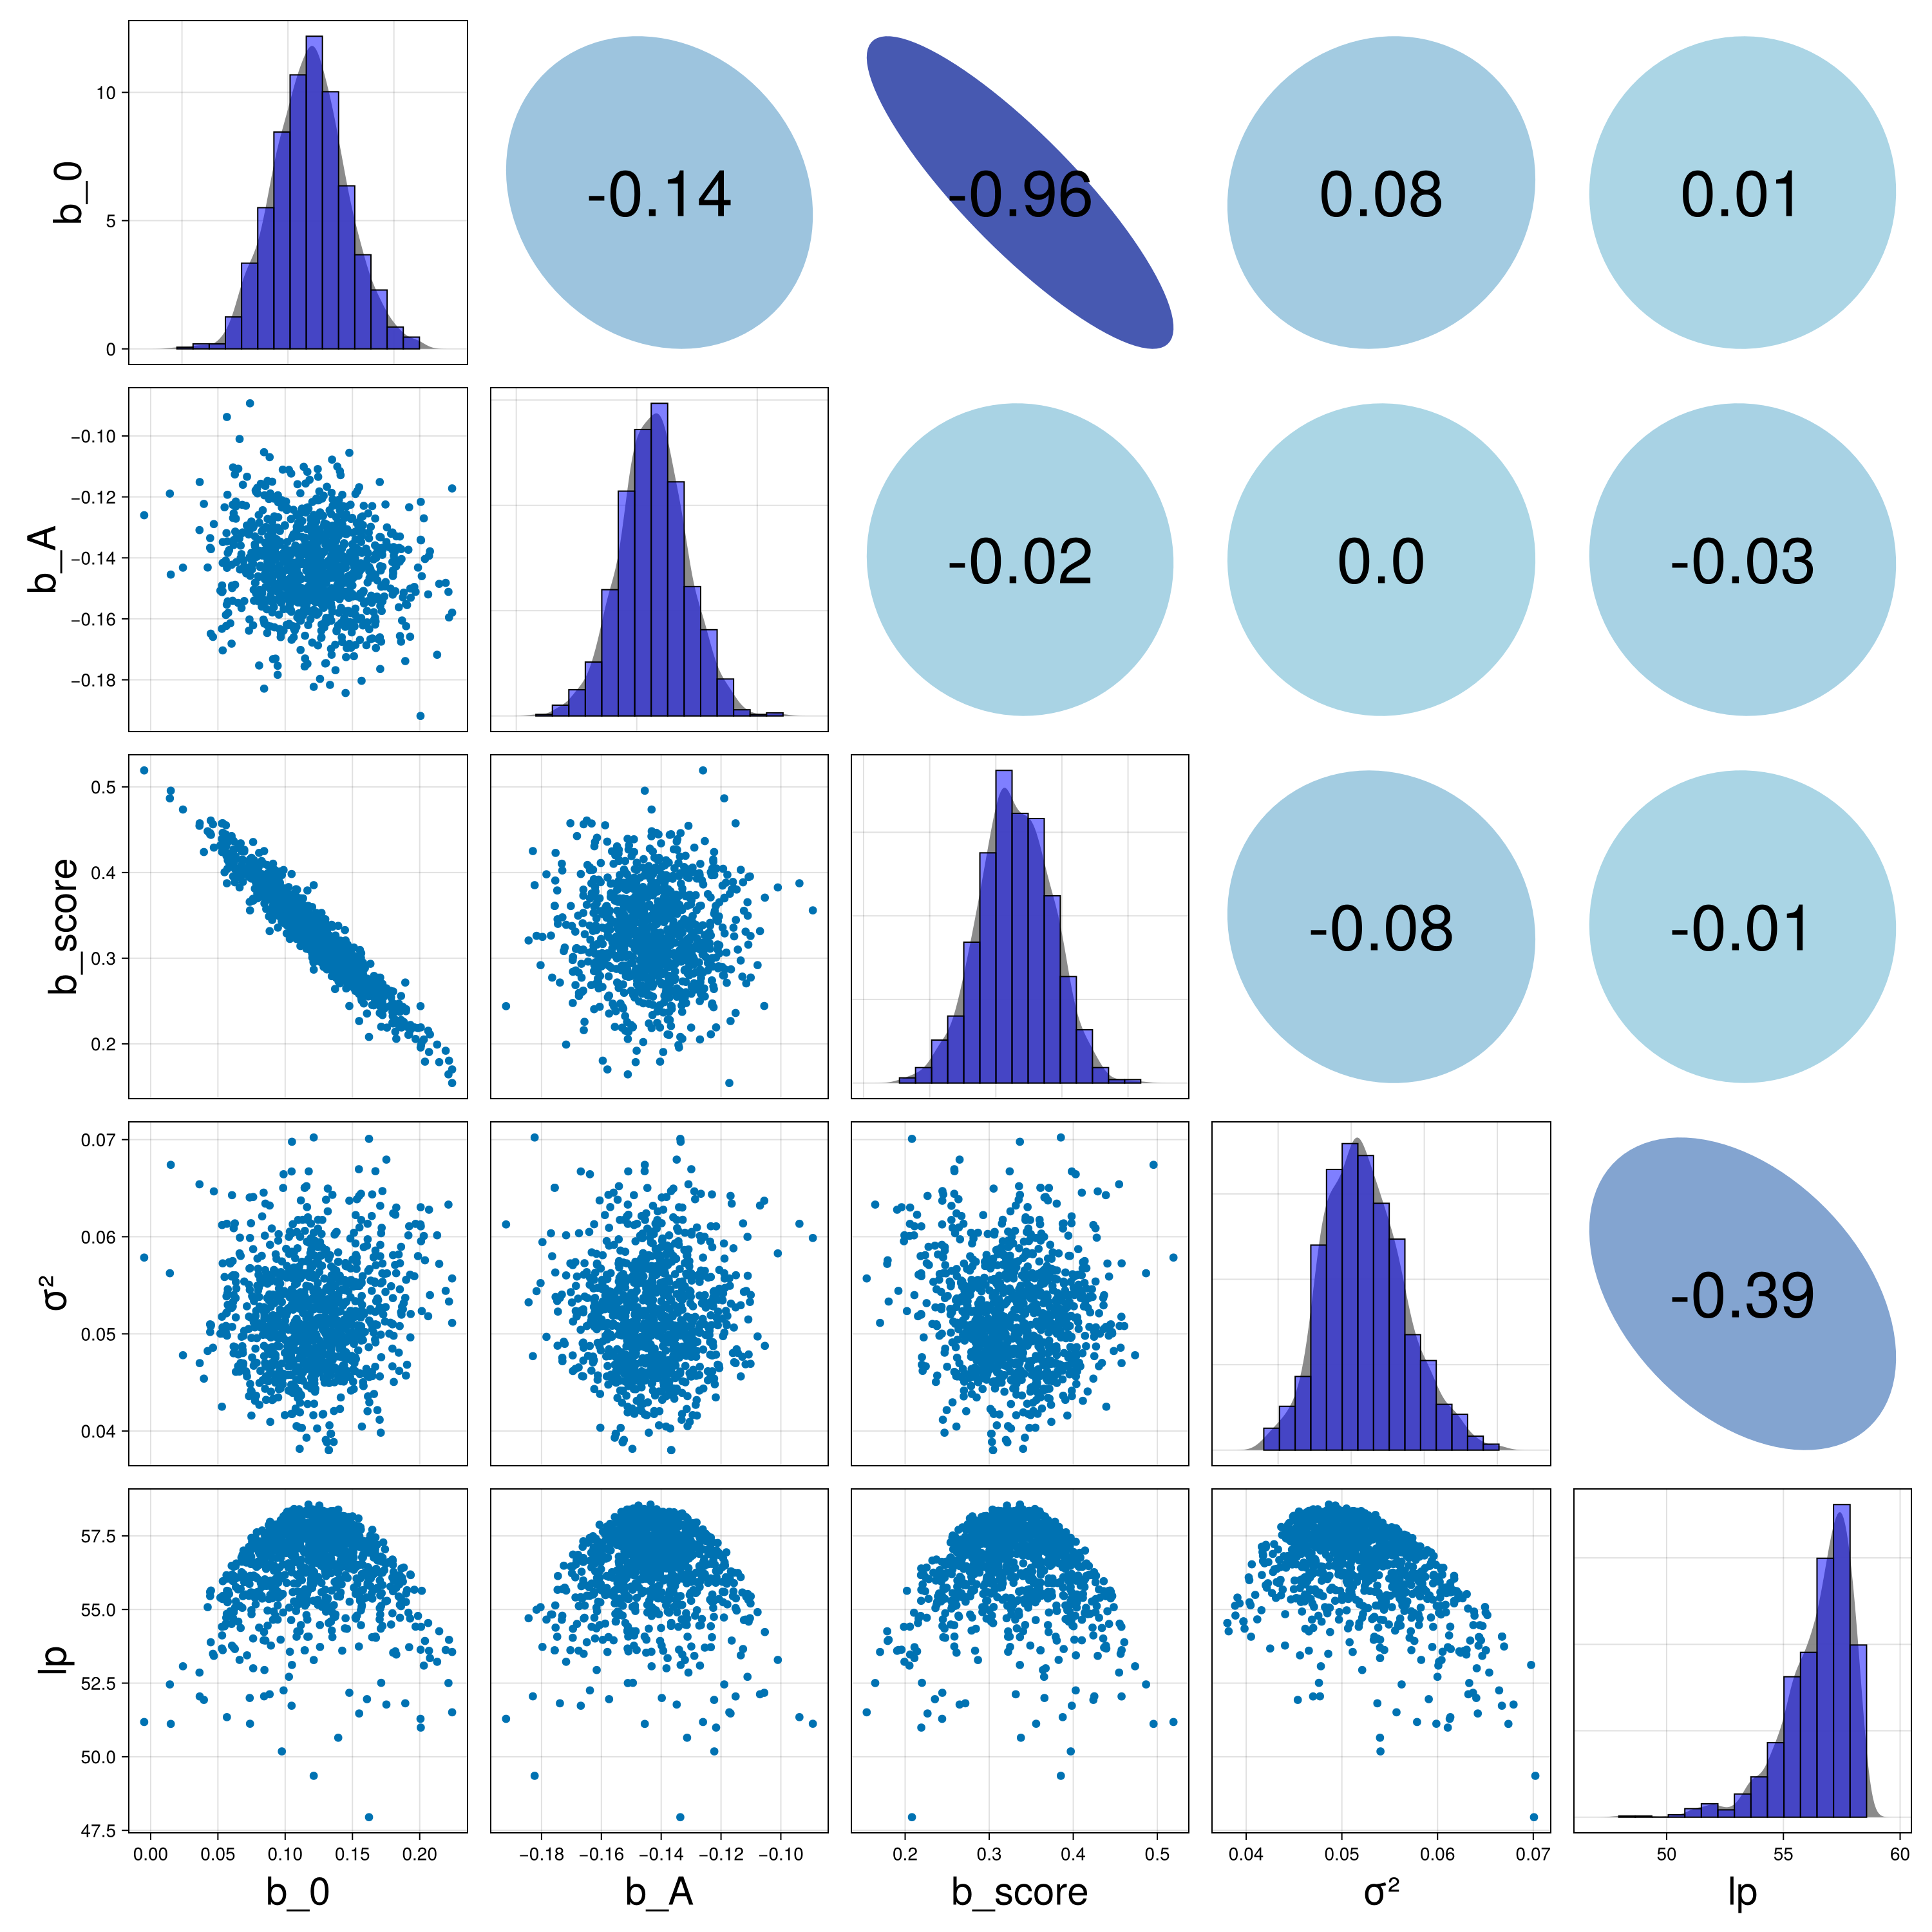

CairoMakie.Screen{IMAGE}


In [50]:
scatter_matrix2(df2, [:b_0, :b_A, :b_score, :σ², :lp])